In [1]:
%matplotlib inline
from datavyz import ge

Need to be in parent directory (e.g. cd ..)

In [2]:
cd /home/yann/work/zinc-NMDA-modulation/

/home/yann/work/zinc-NMDA-modulation


# Calibration of model parameters based on our recordings

In [3]:
### Running scans over grids for model parameters
from model import Model # the grid bounds are stored in the model file

import numpy as np
import os
from analyz.workflow.batch_run import GridSimulation, bash_script

## EXTRA-STIMULATION & NMDA PROPS
GRID = {'tauDecayNMDA': np.linspace(Model['tauDecayNMDA_min'], Model['tauDecayNMDA_max'], Model['N_tauDecayNMDA']),
        'Nsyn1':np.linspace(Model['Nsyn1_min'], Model['Nsyn1_max'], Model['N_Nsyn1'], dtype=int),
        'Nsyn2':np.linspace(Model['Nsyn2_min'], Model['Nsyn2_max'], Model['N_Nsyn2'], dtype=int),
        'Tnsyn20Hz':np.linspace(Model['Tnsyn20Hz_min'],Model['Tnsyn20Hz_max'],Model['N_Tnsyn20Hz']),
        'Tnsyn3Hz':np.linspace(Model['Tnsyn3Hz_min'],Model['Tnsyn3Hz_max'],Model['N_Tnsyn3Hz'])}

np.savez(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'), **GRID)
# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID)
bs = bash_script('calib-chelated-zinc')
bs.script = sim.build_script('python calibration_runs.py chelated-zinc-calib',
                             base_script=bs.script, simultaneous_runs=3*8)
bs.write(folder='./bash/')

## Print output of minization

In [5]:
from analyz.IO.npz import load_dict
from model import add_value_to_study_data
D = load_dict('./data/best_chelatedZn_config.npz')

for key in ['Nsyn1', 'Nsyn2']:
    add_value_to_study_data(key, int(D[key]))
    print(key, int(D[key]))
for key in ['Tnsyn20Hz', 'Tnsyn3Hz', 'tauDecayNMDA']:
    add_value_to_study_data(key, '%.1f ms' % D[key])
    print(key, '%.1f ms' % D[key])

Nsyn1 6
Nsyn2 6
Tnsyn20Hz 30.0 ms
Tnsyn3Hz 70.0 ms
tauDecayNMDA 60.0 ms


INFO       Cache size for target "cython": 15392 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/yann/.cython/brian_extensions" directory. [brian2]


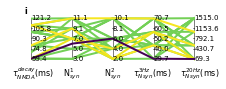

In [6]:
from calibration_runs import compute_chelated_residual, compute_free_residual
from analyz.IO.npz import load_dict
from datavyz import ge
from analyz.workflow.batch_run import GridSimulation
import os

calib_data = load_dict('./data/exp_data_for_calibration.npz')
Residuals = np.load('./data/calib/chelatedZn-residuals.npy')
sim = GridSimulation(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'))
D, X, R, COLORS = {}, [], [], []

Nplot = 20
pResiduals = np.ones(Nplot+1)*np.inf
for j, i in enumerate(np.random.choice(np.arange(int(sim.N)), Nplot)):
    pResiduals[j] = np.log10(Residuals[j])
    sim.update_dict_from_GRID_and_index(i, D)
    X.append([D[k] for k in sim.GRID])
D = load_dict('./data/best_chelatedZn_config.npz')
X.append([D[k] for k in sim.GRID])
pResiduals[-1] = np.min(Residuals)

Colors = (pResiduals-pResiduals.min())/(pResiduals.max()-pResiduals.min())
fig21, ax = ge.parallel_plot(X,
                 SET_OF_LABELS=['  $\\tau_{NMDA}^{decay}$(ms)',
                                'N$_{syn}^{1}$', 'N$_{syn}^{2}$', 
                                '$\\tau_{Nsyn}^{3Hz}$(ms)  ', '    $\\tau_{Nsyn}^{20Hz}$(ms)'],
                             COLORS=[ge.viridis_r(c) for c in Colors],lw=2)
ge.top_left_letter(ax, 'i', loc=(-0.02,1.))

We simplify to one time-constant only

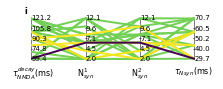

In [6]:
from calibration_runs import compute_chelated_residual, compute_free_residual
from analyz.IO.npz import load_dict
from datavyz import ge
from analyz.workflow.batch_run import GridSimulation
import os

calib_data = load_dict('./data/exp_data_for_calibration.npz')
Residuals = np.load('./data/calib/chelatedZn-residuals.npy')
sim = GridSimulation(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'))
D, X, R, COLORS = {}, [], [], []

Nplot = 20
pResiduals = np.ones(Nplot+1)*np.inf
for j, i in enumerate(np.random.choice(np.arange(int(sim.N)), Nplot)):
    pResiduals[j] = np.log10(Residuals[j])
    sim.update_dict_from_GRID_and_index(i, D)
    X.append([D[k] for k in sim.GRID])
D = load_dict('./data/best_chelatedZn_config.npz')
X.append([D[k] for k in sim.GRID])
pResiduals[-1] = np.min(Residuals)

Colors = (pResiduals-pResiduals.min())/(pResiduals.max()-pResiduals.min())
fig21, ax = ge.parallel_plot([x[:-1] for x in X],
                 SET_OF_LABELS=['  $\\tau_{NMDA}^{decay}$(ms)',
                                'N$_{syn}^{1}$', 'N$_{syn}^{2}$', 
                                '$\\tau_{Nsyn}$(ms)  '],
                             COLORS=[ge.viridis_r(c) for c in Colors],lw=2)
ge.top_left_letter(ax, 'i', loc=(-0.02,1.))
ge.savefig(fig21, 'model-calibration/figures/fig21.svg')

In [7]:
from analyz.IO.npz import load_dict
%matplotlib inline
from datavyz import ge
best = load_dict('./data/best_chelatedZn_config.npz')
sim = GridSimulation(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'))
D = {}
norm = {}
for k in ['tauDecayNMDA', 'Nsyn1', 'Nsyn2', 'Tnsyn20Hz', 'Tnsyn3Hz']:
    norm[k]=(sim.GRID[k][-1]-sim.GRID[k][0])
    
def distance_from_best_config(best, new):
    distance = 0
    for k in ['tauDecayNMDA', 'Nsyn1', 'Nsyn2', 'Tnsyn20Hz', 'Tnsyn3Hz']:
        # distance += np.sqrt((best[k]-new[k])**2/best[k]**2)
        distance += (best[k]-new[k])**2/norm[k]**2
    return distance

Residuals = np.load(os.path.join('data', 'calib', 'chelatedZn-residuals.npy'))
Distance = np.zeros(sim.N)
for i in np.arange(int(sim.N)):
    sim.update_dict_from_GRID_and_index(i, D)
    Distance[i] = distance_from_best_config(best, D)

bins = np.linspace(0, Distance.max(), 20)
ibins = np.digitize(Distance, bins=bins, right=True)
d, r, sr, sr1, sr2 = [], [], [], [], []
for i, b in enumerate(bins[:-1]):
    d.append(.5*(bins[i]+bins[i+1]))
    r.append(np.mean(Residuals[ibins==i]))
    sr.append(np.std(Residuals[ibins==i]))
    cond = Residuals[ibins==i]<r[-1]
    sr1.append(np.std(Residuals[ibins==i][cond]))
    cond = Residuals[ibins==i]>=r[-1]
    sr2.append(np.std(Residuals[ibins==i][cond]))

fig22, ax = ge.plot(d, r, sy1=np.array(sr1), sy2=np.array(sr2),
        axes_args=dict(ylabel='$\chi^2$-residual        ',
                       yscale='log',
                       # ylim=[0.8,22.],
                       # yticks=[1, 2, 5, 10, 20], yticks_labels=['1', '2', '5', '10', '20'],
                       xlabel='dist. from best config (a.u.)          '))
ge.annotate(ax, ' %iconfigs' % sim.N, (0., 1.), size='small', va='top')
ge.top_left_letter(ax, 'ii', loc=(-0.4,1.))
ge.savefig(fig22, 'model-calibration/figures/fig22.svg')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4032 but corresponding boolean dimension is 2800

## Calibrating Zinc-NMDA properties on Extracellular stimulation data

In [26]:
import os
import numpy as np
from analyz.workflow.batch_run import slurm_script, bash_script, GridSimulation
from analyz.IO.npz import load_dict

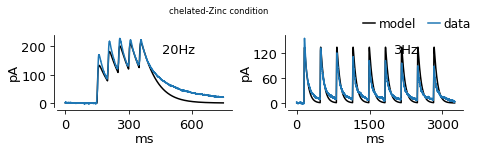

In [8]:
from datavyz import ges as ge
from analyz.IO.npz import load_dict
fig, AX = ge.figure(axes=(2,1), figsize=(1.2,0.8), wspace=0.5, hspace=0)

calib_data = load_dict('./data/exp_data_for_calibration.npz')
mdata = load_dict('./'+load_dict('./data/best_chelatedZn_config.npz')['filename'])

for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    ## data
    tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
        (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
         calib_data['DTfull_%s' % cond])
    
    trace_model = -1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])
    trace_exp = calib_data['Iexp_chelatedZn_%s' % cond]
    
    ax.plot(calib_data['t_%s' % cond], trace_model, color=ge.default_color, label='model')
    ax.plot(calib_data['t_%s' % cond], trace_exp, color=ge.blue, label='data')

    ge.set_plot(ax, ylabel='pA', xlabel='ms')
    ge.annotate(ax, cond.split('_')[0], (.6, .7))
    
ge.legend(AX[1], size='small', loc=(0.4,1.), ncol=2)
fig.suptitle('chelated-Zinc condition', color=ge.default_color, size='small');

In [24]:
np.linspace(3, 11, 5)

array([ 3.,  5.,  7.,  9., 11.])